# Лабораторная работа №3
## Метод сеток решения одномерного нестационарного уравнения теплопроводности
### Вариант 19. Задачи 2.3.19 и 2.4.2
*Задание 2.* Промоделировать стационарные процессы теплопроводности стержня в зависимости от входных данных задач переменного коэффициента теплопроводности $k(x)$ и плотности источников тепла $f(x)$:

$$\begin{equation}
  \begin{cases}
    -\frac{d}{dx}(k(x)\frac{du}{dx}) = f,\\
    u(a) = U_A, u(b) = U_B.
  \end{cases}
\end{equation}$$

*Задание 3.* Промоделировать нестационарные процессы теплопроводности в зависимости от входных данных задачи − коэффициента теплопроводности и начальной температуры:

$$\begin{equation}
  \begin{cases}
    \frac{d}{dt}=\frac{d}{dx}((k(x)\frac{du}{dx})+f(x)(1-e^{-t}),  0 < x < l, 0 < t < T \\
    u(0, t) = U_A, u(l,b) = U_B,  0 \le t \le T,\\
    u(x, 0) = \phi(x), 0 \le x \le t.
  \end{cases}
\end{equation}$$

*Задание 4.* Промоделировать нестационарные процессы теплопроводности в зависимости от входных данных задачи. Найти приближенное решение начально-краевой задачи для уравнения теплопроводности:

$$\begin{equation}
  \begin{cases}
    \frac{d}{dt}=k\frac{d^2u}{dx^2}+f(x,t),  a < x < b, 0 < t \le T \\
    u(a, t) = g_1(t), u(b,t) = g_2(t),  0 < t \le T,\\
    u(x, 0) = \phi(x), a \le x \le b.
  \end{cases}
\end{equation}$$


### Задание 2.
$a = 0$, $b = 1$, $U(a) = 0$, $U(b) = 0$


In [4]:
# importing necessary libraries

import numpy as np
import scipy as sp
from scipy.misc import derivative 
from scipy import sparse
from scipy import integrate
import matplotlib.pyplot as plt

In [5]:
a = 0
b = 1
h = (b - a) / 150
ua = 0
ub = 0

Решать будем **методом баланса**.

Для данного уравнения получим консервативную разностную схему:

$$\begin{equation}
  \begin{cases}
    \frac{1}{h}(b_n\frac{y_{n+1}-y_n}{h}-a_n\frac{y_n-y_{n-1}}{h})=-\phi_n, n = 1,2,...N-1 \\
    y_0=g_1, y_n=g_2.
  \end{cases}
\end{equation}$$

, где: 

$a_n = (\frac{1}{h} \int_{x_{n-1}}^{x_n} \frac{dx}{k(x)})^{-1}$, 

$b_n = (\frac{1}{h} \int_{x_{n}}^{x_{n+1}} \frac{dx}{k(x)})^{-1}$, 

$\phi_n = \frac{1}{h} \int_{x_{n-0.5}}^{x_{n+0.5}} f(x)dx$, 

$g_1=u(a), g_2=u(b)$.

Раскроем скобки:

$ \frac{a_n}{h^2} y_{n-1} - \frac{a_n + b_n}{h^2}y_n + \frac{b_n}{h^2}y_{n+1} = -\varphi_n$

In [6]:
def A(x, k1, k2, k3, xr1, xr2):
    if x < xr1:
        return k1
    elif x-h < xr1 < x:
        return h / ((xr1 - x + h) / k1 + (x - xr1) / k2)
    elif x <= xr2:
        return k2
    elif x-h < xr2 < x:
        return h / ((xr2 - x + h) / k2 + (x - xr2) / k3)
    else:
        return k3

In [7]:
def B(x, k1, k2, k3, xr1, xr2):
    if x < xr1:
        return k1
    elif x < xr1 < x+h:
        return h / ((xr1 - x) / k1 + (x+h - xr1) / k2)
    elif x+h <= xr2:
        return k2
    elif x < xr2 < x+h:
        return h / ((xr2 - x) / k2 + (x+h - xr2) / k3)
    else:
        return k3

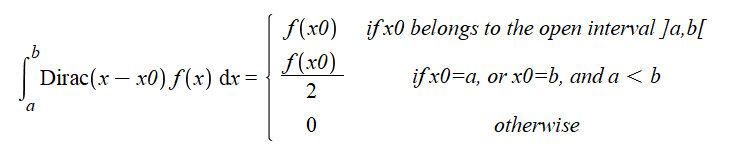

In [8]:
def phi(x, x0, C):
    if abs(x - x0) - h/2 < 1e-5:
        return C/2
    elif x - h/2 < x0 < x + h/2:
        return C
    else:
        return 0

In [9]:
def solve2(a, b, ua, ub, h, k1, k2, k3, xr1, xr2, phi_conds):
    n = int((b - a) / h) + 1
    M = np.zeros(shape=(n, n))
    Y = np.zeros(n)
    M[0, 0] = 1
    M[-1, -1] = 1
    Y[0] = ua
    Y[-1] = ub
    for i in range(1, n - 1):
        xi = a + h * i
        M[i, i - 1] = A(xi, k1, k2, k3, xr1, xr2)
        M[i, i] = -(A(xi, k1, k2, k3, xr1, xr2) + B(xi, k1, k2, k3, xr1, xr2))
        M[i, i + 1] = B(xi, k1, k2, k3, xr1, xr2)
        Y[i] = - h * sum(phi(xi, x0, C) for x0, C in phi_conds)
    #print(M)
    return np.linspace(a, b, n), np.linalg.solve(M, Y)

In [10]:
# set what consists of k1, k2, k3, xr1, xr2

sets = [
    [1, 100, 0, (b + a)/2, 2*b],
    [100, 1, 0, (b + a)/2, 2*b],
    [10, 25, 75, a + (b - a)/3, a + 2*(b - a)/3],
    [100, 40, 15, a + (b - a)/3, a + 2*(b - a)/3],
    [30, 60 , 30, a + (b - a)/3, a + 2*(b - a)/3],
    [100, 5, 100, a + (b - a)/3, a + 2*(b - a)/3]
]

conditions = [
    [((b + a)/2, 20)],
    [((b + a)*(0.5 - 0.3), 20), ((b + a)*(0.5 + 0.3), 20)],
    [((b + a)*(0.5 - 0.3), 20), ((b + a)*(0.5 + 0.3), 200)]
]

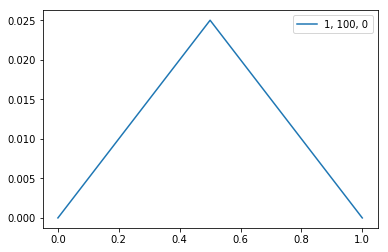

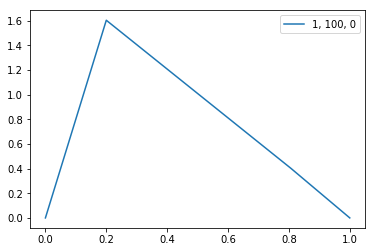

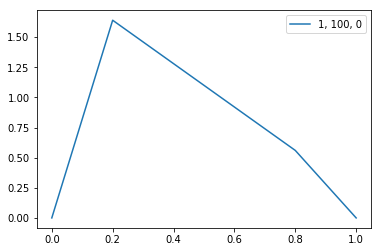

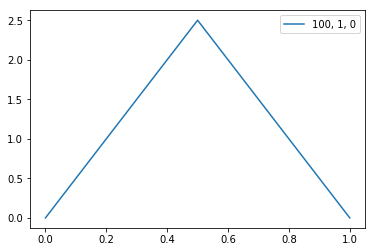

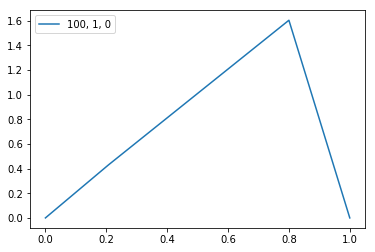

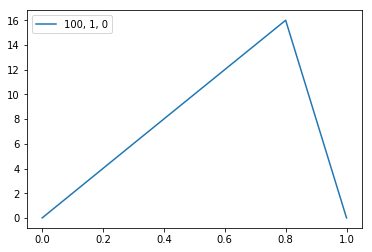

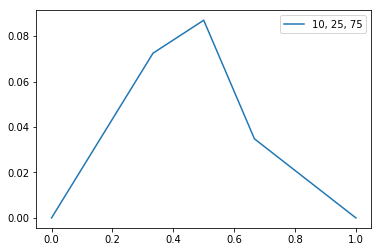

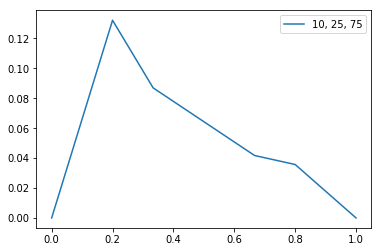

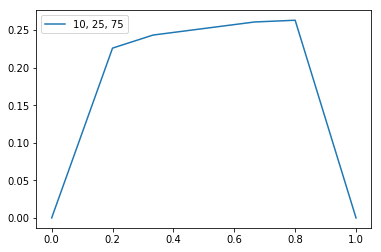

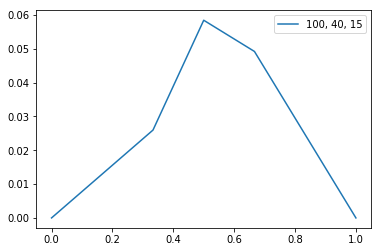

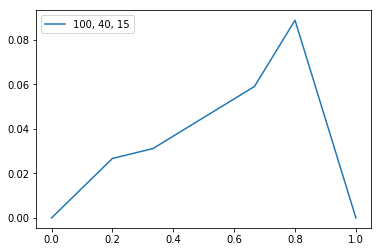

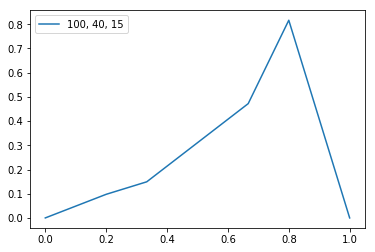

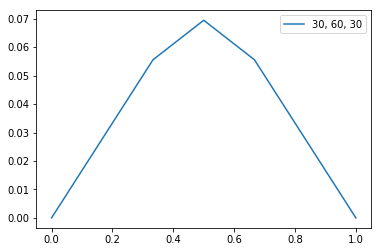

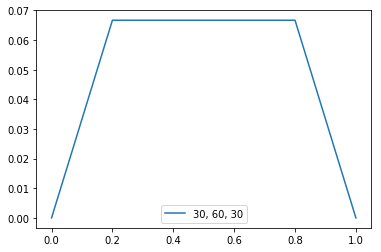

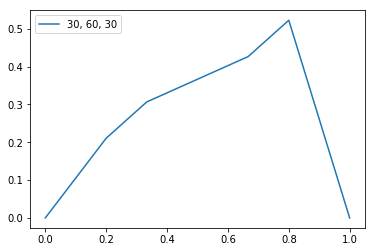

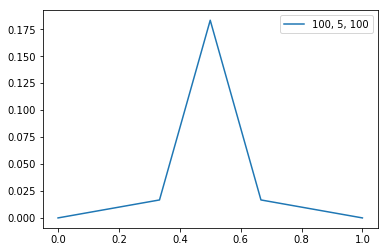

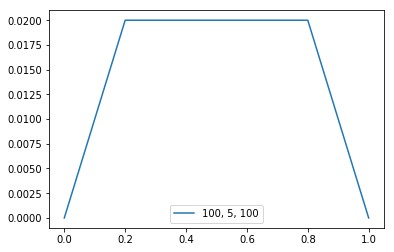

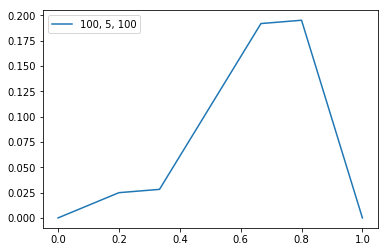

In [11]:
for s in sets:
    for conds in conditions:
        plt.plot(*solve2(a, b, ua, ub, h, *s, conds), label='{}, {}, {}'.format(*s))
        plt.plot()
        plt.legend()
        plt.show()

### Задание 3

Пусть оператор $L$ равен:

$$
Lu = \frac{\partial u}{\partial t} - \frac{\partial}{\partial x}(k(x)\frac{\partial u}{\partial x})
$$

Аппроксимируем частичные производные:

$$
\frac{\partial u}{\partial t} = \frac{u(x, t + \tau) - u(x, t)}{\tau}
$$

$$
\frac{\partial}{\partial x}(k(x)\frac{\partial u}{\partial x}) = \frac{k(x+\frac{h}{2})[u(x+h, t) - u(x, t)] - k(x - \frac{h}{2})[u(x, t) - u(x - h, t)]}{h^2}
$$

Тогда $L$ равен: 

$$
Lu = \frac{u(x, t + \tau) - u(x, t)}{\tau}- \frac{k(x+\frac{h}{2})[u(x+h, t) - u(x, t)] - k(x - \frac{h}{2})[u(x, t) - u(x - h, t)]}{h^2} + f(x)(1-e^{-t})
$$

Выразим отсюда $u(x, t+\tau)$:

$$
u(x, t+\tau)= \frac{\tau}{h^2}k(x+\frac{h}{2})u(x+h,t)+[1 - \frac{\tau}{h^2}(k(x+\frac{h}{2})+k(x-\frac{h}{2})]u(x,t) + \frac{\tau}{h^2}k(x-\frac{h}{2})u(x-h,t) + \tau f(x)(1-e^{-t})
$$

In [23]:
# initial data
a = 0.2
b = 1.2
ua = lambda t: 4.
ub = lambda t: 1.
k = lambda x: x 
f = lambda x: 4.*x*x*x + 6.
phi = lambda x: -10*x*x + 11 * x + 2.2
h = 0.05
t = 0.001
K = int((b - a)/h) + 1
T = 501
print(K)

21


In [13]:
def solve3():
    M = np.zeros(shape=(T, K))
    M[:,0] = np.array([ua(i) for i in np.linspace(0, T, T)])
    M[:,-1] = np.array([ub(i) for i in np.linspace(0, T, T)])
    M[0,:] = np.array([phi(xi) for xi in np.linspace(a, b, K)])
    #print(M)
    for i in range(1, T):
        for j in range(1, K-1):
            xj = a + j*h
            M[i][j] = k(xj + h/2)*M[i-1][j+1]*t/(h*h) + \
                      (1 - (k(xj + h/2) + k(xj - h/2))*t/(h*h)) * M[i-1][j] + \
                      k(xj - h/2)*M[i-1][j-1]*t/(h*h) + \
                      t*f(xj)*(1 - np.exp(-i*t))
    return M

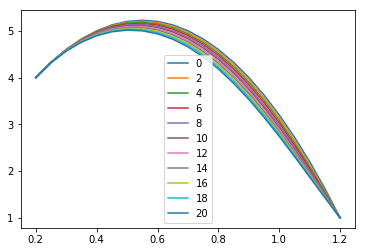

In [24]:
matrix = solve3()
X = np.linspace(a, b, K)

for i in range(0, 21, 2):
    plt.plot(X, matrix[i], label=i)
plt.legend()
plt.show()

### Задание 4
В силу того, что $k$ теперь константа, получим:

$$
u(x, t+\tau)= \frac{k\tau}{h^2}u(x+h,t)+[1 - \frac{2k\tau}{h^2}]u(x,t) + \frac{k\tau}{h^2}u(x-h,t) + \tau f(x)
$$


In [15]:
# initial data
a = 0
b = 1
ua = lambda t: 1
ub = lambda t: 0
k = 0.2
f = lambda x: 0
phi = lambda x: 1 - x*x
h = (b - a) / 50
t = 0.5 * h*h /k
T = 0.2
nK = int((b - a)/h) + 1
nT = int(T/t)+1

In [16]:
def solve4():
    M = np.zeros(shape=(nT, nK))
    M[:,0] = np.array([ua(i) for i in np.linspace(0, T, nT)])
    M[:,-1] = np.array([ub(i) for i in np.linspace(0, T, nT)])
    M[0,:] = np.array([phi(xi) for xi in np.linspace(a, b, nK)])
    #print(M)
    for i in range(1, nT):
        for j in range(1, nK-1):
            xj = a + j*h
            M[i][j] = k * M[i-1][j+1]*t/(h*h) + \
                      (1 - 2*k*t/(h*h)) * M[i-1][j] + \
                      k*M[i-1][j-1]*t/(h*h) + \
                      t*f(xj)
    return M

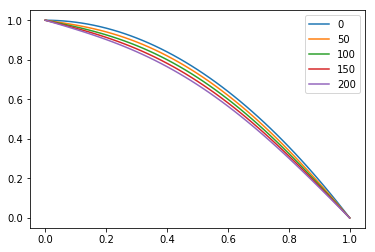

In [17]:
matrix = solve4()
X = np.linspace(a, b, nK)

for i in range(0, nT, 50):
    plt.plot(X, matrix[i], label=i)
plt.legend()
plt.show()